# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(labels_map=labels)
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2357960


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, result_path, test_size={"neg": 10000, "pos": 1000},
                        train_size={"neg": 20000, "pos": 20000}, meta_data_cols=meta_data_cols)

Setting training and test sets


  4%|▎         | 412/11000 [00:00<00:06, 1747.25feature/s]

Graph loaded


114761feature [00:49, 2328.33feature/s]                     
  0%|          | 108/40000 [00:00<00:37, 1068.05feature/s]

Features were written to: /Users/vhying/Desktop/CS 221/CS 221 - 2019A/Project/Network-Anomaly-Detection/data/temp/twitter__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:21<00:00, 1899.38feature/s]


Features were written to: /Users/vhying/Desktop/CS 221/CS 221 - 2019A/Project/Network-Anomaly-Detection/data/temp/twitter__train.csv
Training 10-fold validation: {'auc': 0.9710907875, 'recall': 0.9182, 'precision': 0.9211798983943253, 'accuracy': 0.9197999999999998, 'fpr': 0.07859999999999999, 'tnr': 0.9214}


{'auc': 1.0,
 'recall': 0.4666666666666667,
 'precision': 0.06140350877192982,
 'accuracy': 0.9363938053097345,
 'fpr': 0.05967651979921919}

In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [10]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [11]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3595,2104351,0.042308,13,0.957692,1.000000,13,1,1,1,1
3005,709798,0.312654,19,0.687346,1.000000,19,1,0,1,2
3282,955631,0.070007,18,0.929993,0.944444,17,1,0,1,3
1769,215410,0.241528,12,0.758472,0.916667,11,1,1,2,4
3230,880719,0.300740,16,0.699260,0.812500,13,1,1,3,5
3564,1886070,0.250000,13,0.750000,0.769231,10,1,0,3,6
3488,1455795,0.308812,24,0.691188,0.750000,18,1,1,4,7
293,17643,0.276077,16,0.723923,0.750000,12,1,0,4,8
2666,496941,0.343593,15,0.656407,0.733333,11,1,1,5,9
1770,215624,0.396444,15,0.603556,0.733333,11,1,1,6,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [12]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [13]:
df[["k", "p@k"]].head(10)

,k,p@k
3595,1,1.000000
3005,2,0.500000
3282,3,0.333333
1769,4,0.500000
3230,5,0.600000
3564,6,0.500000
3488,7,0.571429
293,8,0.500000
2666,9,0.555556
1770,10,0.600000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

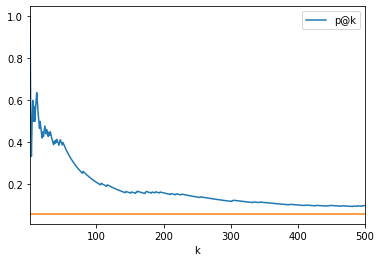

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))